In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import random


2025-11-20 13:36:10.729671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 13:36:10.753847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763642170.774702   29396 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763642170.781369   29396 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763642170.804422   29396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import os

base_path = ""
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
valid_path = os.path.join(base_path, "Validation")

#image classes
image_classes = os.listdir("")
image_classes

['Non Defective', 'Defective']

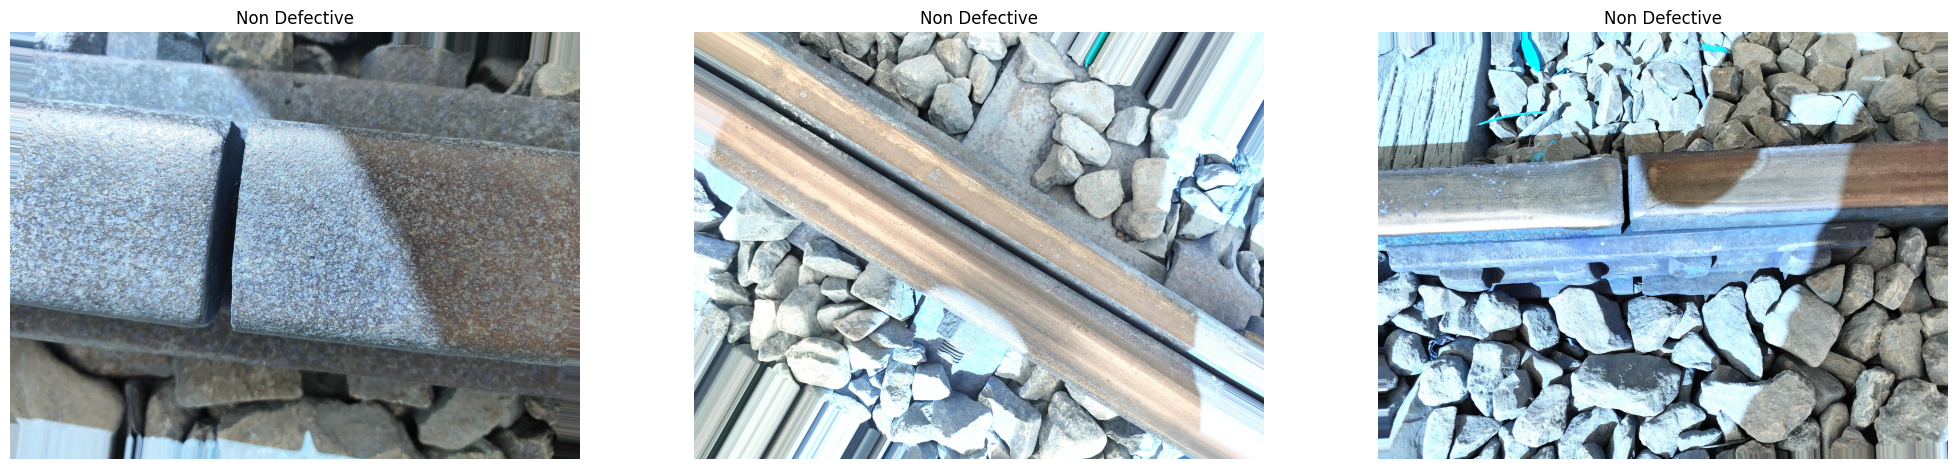

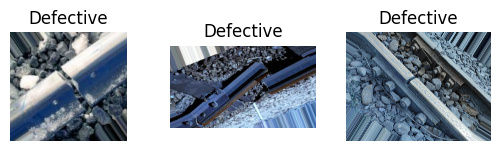

In [3]:
from PIL import Image
def plot_images(image_classes):
    plt.figure(figsize = (25, 25))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + "/" + category
        image_in_folder = os.listdir(image_path)
        
        for j in range(3):
            omage = image_in_folder[j]
            omage_path = image_path + "/" + omage
        
            img = image.load_img(omage_path)
            img_array = image.img_to_array(img) / 255
            
            plt.subplot(3,3, j+1)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis("off")
        plt.show()

plot_images(image_classes)

In [4]:
from tensorflow.keras.applications.nasnet  import preprocess_input

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_data_noaug = image_generator.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = "categorical")

Found 560 images belonging to 2 classes.


In [6]:
test_data = image_generator.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                batch_size = 1,
                                                class_mode = "categorical")

Found 80 images belonging to 2 classes.


In [7]:
valid_data = image_generator.flow_from_directory(valid_path,
                                                target_size = (224, 224),
                                                batch_size = 16,
                                                class_mode = "categorical")

Found 158 images belonging to 2 classes.


In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)

In [ ]:
from tensorflow.keras.applications import NASNetMobile

def build_NASNetMobile_model():

    model=NASNetMobile(input_shape=(224,224,3),weights='imagenet',include_top=False)
    model.trainable = False

    x = model.output
    # CLASSIFICATION
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='gelu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='gelu')(x)
    y = Dense(2, activation = "softmax")(x)
    return Model(inputs=model.input, outputs=y)

set_seed(42)
model_noaug = build_NASNetMobile_model()

I0000 00:00:1763642178.362495   29396 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
model_noaug.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])


In [ ]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

In [12]:
model_noaug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,574,486 (17.45 MB)

 Trainable params: 304,258 (1.16 MB)

 Non-trainable params: 4,270,228 (16.29 MB)

In [13]:
model_history = model_noaug.fit(train_data_noaug, 
                         epochs = 30,
                         validation_data = valid_data,
                         callbacks = [early_stopping])
model_noaug.save("NASNetMobile_trained_with_Rail_Only.keras")


/home/jasser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763642204.583585   29601 cuda_dnn.cc:529] Loaded cuDNN version 91002


18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7277 - loss: 0.6326 - val_accuracy: 0.8861 - val_loss: 0.3133
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9380 - loss: 0.1589 - val_accuracy: 0.9304 - val_loss: 0.2242
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9491 - loss: 0.1022 - val_accuracy: 0.9177 - val_loss: 0.1870
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9620 - loss: 0.0809 - val_accuracy: 0.9367 - val_loss: 0.1648
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9807 - loss: 0.0606 - val_accuracy: 0.9241 - val_loss: 0.2188
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9857 - loss: 0.0696 - val_accuracy: 0.9241 - val_loss: 0.2031
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9959 - loss: 0.0269 - val_accuracy: 0.9620 - val_loss: 0.1713
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9971 - loss: 0.0227 - val_accuracy: 0.9430 - val_loss: 0.1820
Epo

In [14]:
model_noaug.evaluate(test_data)

80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.7797 - loss: 0.3913


[0.3140687942504883, 0.8374999761581421]

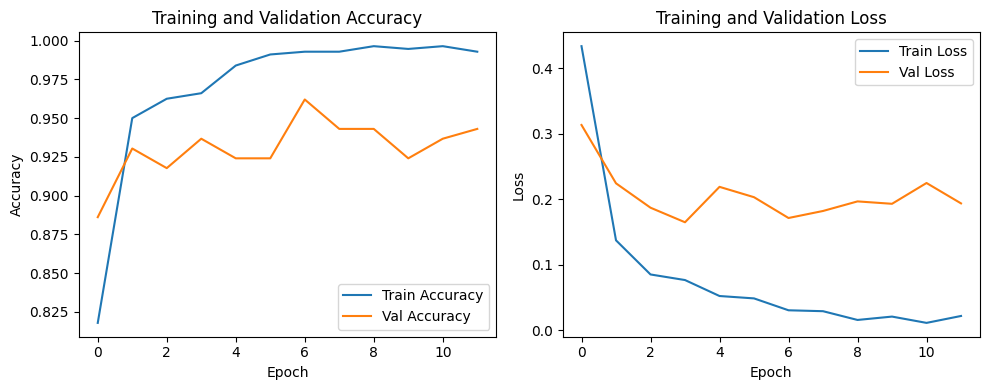

In [15]:
plt.figure(figsize=(10,4))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 80 images belonging to 2 classes.
📊 Classification Report:

               precision    recall  f1-score   support

    Defective       0.94      0.72      0.82        40
Non Defective       0.78      0.95      0.85        40

     accuracy                           0.84        80
    macro avg       0.86      0.84      0.84        80
 weighted avg       0.86      0.84      0.84        80



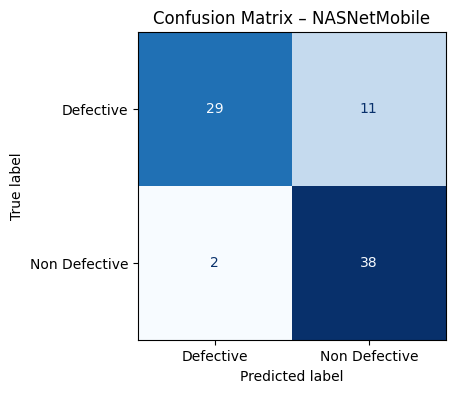

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

test_data = image_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

test_data.reset()

pred_probs = model_noaug.predict(test_data, verbose=0)

y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

target_names = list(test_data.class_indices.keys())
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names
)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title('Confusion Matrix – NASNetMobile')
plt.show()
